# Arxiv Policy Impact Analysis

This notebook analyzes the potential disproportionate effects of arxiv's new policy restricting review/position papers in CS until after peer review. We examine:
1. Rate of review/position papers across CS subcategories
2. Rate of AI-generated predictions across subcategories
3. Intersection: which subfields might be most affected

In [17]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

In [18]:
# Load data from all CS subcategories
results_dir = Path('../data/results')

# CS subcategories of interest
cs_categories = [
    'cs-AI',   # Artificial Intelligence
    'cs-CL',   # Computation and Language
    'cs-CR',   # Cryptography and Security
    'cs-CV',   # Computer Vision
    'cs-CY',   # Computers and Society
    'cs-HC',   # Human-Computer Interaction
    'cs-IR',   # Information Retrieval
    'cs-LG',   # Machine Learning
    'cs-RO',   # Robotics
    'cs-SE',   # Software Engineering
]

# Human-readable names
category_names = {
    'cs-AI': 'AI',
    'cs-CL': 'Comp. Ling.',
    'cs-CR': 'Crypto/Security',
    'cs-CV': 'Computer Vision',
    'cs-CY': 'Computers & Society',
    'cs-HC': 'HCI',
    'cs-IR': 'Info. Retrieval',
    'cs-LG': 'Machine Learning',
    'cs-RO': 'Robotics',
    'cs-SE': 'Software Eng.',
}

def load_category_data(category):
    """Load pangram detection results for a category (both post-LLM JSON and pre-LLM CSV)."""
    all_items = []
    
    # Load post-LLM data (2023+) from JSON
    json_path = results_dir / category / 'pangram_detection_results.json'
    if json_path.exists():
        with open(json_path) as f:
            data = json.load(f)
        for item in data:
            item['category'] = category
        all_items.extend(data)
    
    # Load pre-LLM data (2020-2022) from CSV
    csv_path = results_dir / category / 'pre_pangram_detection_results.csv'
    if csv_path.exists():
        pre_df = pd.read_csv(csv_path)
        # Parse the pangram_prediction column from string to dict
        import ast
        pre_df['pangram_prediction'] = pre_df['pangram_prediction'].apply(ast.literal_eval)
        pre_df['category'] = category
        all_items.extend(pre_df.to_dict('records'))
    
    return all_items

# Load all data
all_data = []
for cat in cs_categories:
    all_data.extend(load_category_data(cat))

df = pd.DataFrame(all_data)
print(f"Loaded {len(df)} papers across {df['category'].nunique()} categories")
print(f"Year range: {df['year'].min()}-{df['year'].max()}")

Loaded 40507 papers across 10 categories
Year range: 2020-2025


In [19]:
# Extract prediction info
df['ai_prediction'] = df['pangram_prediction'].apply(lambda x: x['prediction'])
df['ai_likelihood'] = df['pangram_prediction'].apply(lambda x: x['ai_likelihood'])

# Binary flags
df['is_review'] = df['paper_type'].isin(['review', 'other'])  # review or position papers
df['is_ai_flagged'] = df['ai_prediction'].isin(['Likely AI', 'Highly Likely AI'])
df['is_possibly_ai'] = df['ai_prediction'].isin(['Possibly AI', 'Likely AI', 'Highly Likely AI'])

df['category_name'] = df['category'].map(category_names)

df.head()

,arxiv_id,paper_type,period,year,month,pangram_prediction,category,ai_prediction,ai_likelihood,is_review,is_ai_flagged,is_possibly_ai,category_name
0,2301.08490,regular,post_llm,2023,1,"{'ai_likelihood': 0.0395711263, 'text': 'causa...",cs-AI,Unlikely AI,0.039571,False,False,False,AI
1,2301.13869,regular,post_llm,2023,1,"{'ai_likelihood': 1.9537e-06, 'text': 'Reverse...",cs-AI,Unlikely AI,0.000002,False,False,False,AI
2,2301.01837,regular,post_llm,2023,1,"{'ai_likelihood': 1.3577e-06, 'text': 'A Meta-...",cs-AI,Unlikely AI,0.000001,False,False,False,AI
3,2301.12063,regular,post_llm,2023,1,"{'ai_likelihood': 0.0002845128, 'text': 'HAT-G...",cs-AI,Unlikely AI,0.000285,False,False,False,AI
4,2301.07629,regular,post_llm,2023,1,"{'ai_likelihood': 0.0001160304, 'text': 'Gener...",cs-AI,Unlikely AI,0.000116,False,False,False,AI


## 1. Review/Position Paper Rates by Subcategory

This plot shows which CS subcategories have higher proportions of review/position papers that would be affected by the policy.

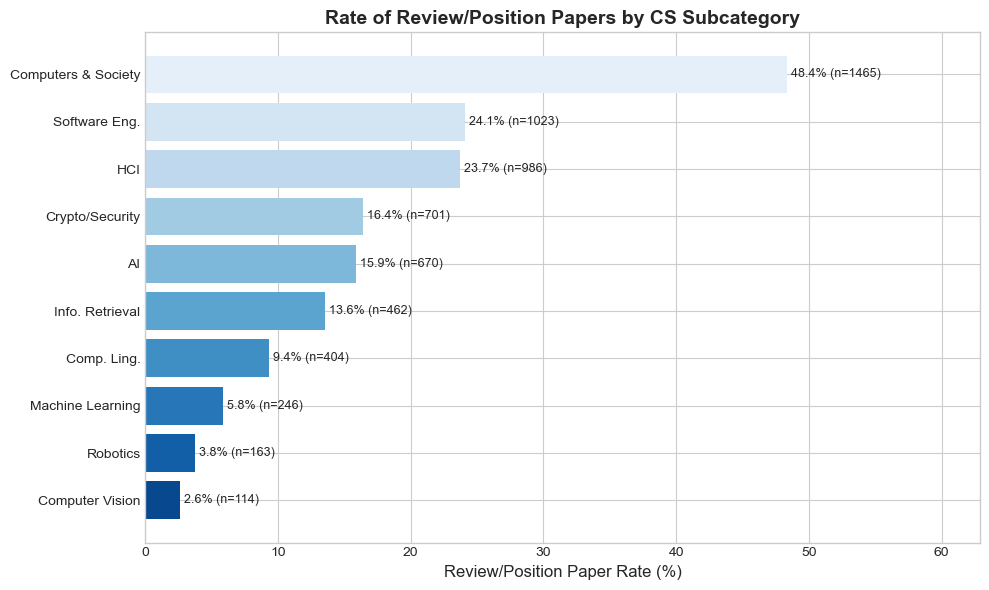

In [20]:
# Calculate review rates by category
review_rates = df.groupby('category_name').agg(
    total_papers=('arxiv_id', 'count'),
    review_papers=('is_review', 'sum'),
    review_rate=('is_review', 'mean')
).reset_index()

review_rates = review_rates.sort_values('review_rate', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(review_rates['category_name'], review_rates['review_rate'] * 100, 
               color=sns.color_palette('Blues_r', len(review_rates)))

ax.set_xlabel('Review/Position Paper Rate (%)', fontsize=12)
ax.set_title('Rate of Review/Position Papers by CS Subcategory', fontsize=14, fontweight='bold')

# Add value labels
for bar, rate, count in zip(bars, review_rates['review_rate'], review_rates['review_papers']):
    ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2, 
            f'{rate*100:.1f}% (n={int(count)})', va='center', fontsize=9)

ax.set_xlim(0, max(review_rates['review_rate'] * 100) * 1.3)
plt.tight_layout()
plt.savefig('../figures/review_rates_by_category.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 2. AI Detection Rates by Subcategory

This shows which subcategories have higher rates of papers flagged as potentially AI-generated.

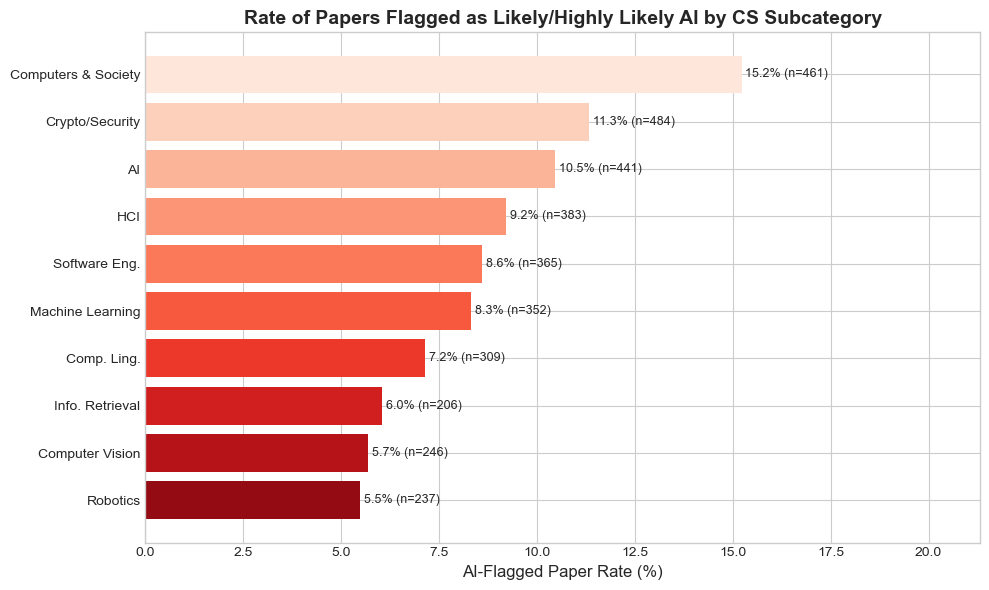

In [21]:
# Calculate AI detection rates by category
ai_rates = df.groupby('category_name').agg(
    total_papers=('arxiv_id', 'count'),
    ai_flagged=('is_ai_flagged', 'sum'),
    ai_rate=('is_ai_flagged', 'mean'),
    possibly_ai=('is_possibly_ai', 'sum'),
    possibly_ai_rate=('is_possibly_ai', 'mean'),
    mean_likelihood=('ai_likelihood', 'mean')
).reset_index()

ai_rates = ai_rates.sort_values('ai_rate', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(ai_rates['category_name'], ai_rates['ai_rate'] * 100,
               color=sns.color_palette('Reds_r', len(ai_rates)))

ax.set_xlabel('AI-Flagged Paper Rate (%)', fontsize=12)
ax.set_title('Rate of Papers Flagged as Likely/Highly Likely AI by CS Subcategory', 
             fontsize=14, fontweight='bold')

# Add value labels
for bar, rate, count in zip(bars, ai_rates['ai_rate'], ai_rates['ai_flagged']):
    ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
            f'{rate*100:.1f}% (n={int(count)})', va='center', fontsize=9)

ax.set_xlim(0, max(ai_rates['ai_rate'] * 100) * 1.4)
plt.tight_layout()
plt.savefig('../figures/ai_rates_by_category.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 3. Combined View: Review Rate vs AI Rate

This scatter plot shows both dimensions together, highlighting subcategories that might be disproportionately affected.

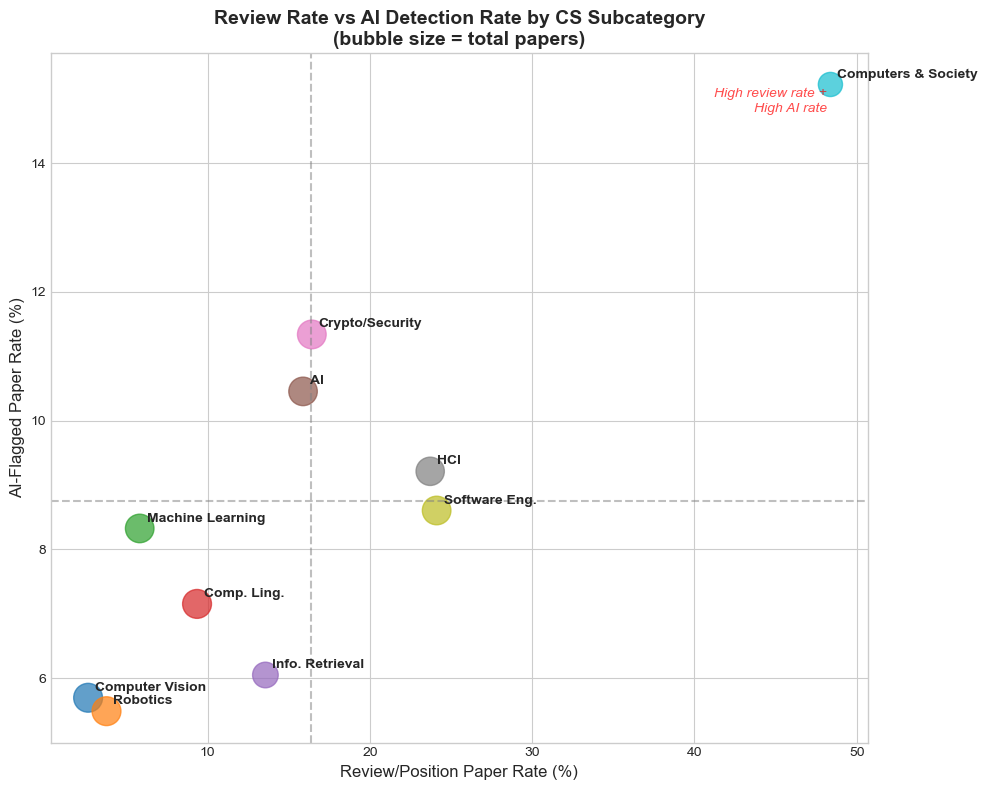

In [22]:
# Merge review and AI rates
combined = review_rates.merge(ai_rates, on='category_name', suffixes=('_rev', '_ai'))

fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot with size proportional to total papers
scatter = ax.scatter(
    combined['review_rate'] * 100,
    combined['ai_rate'] * 100,
    s=combined['total_papers_rev'] / 10,  # Scale for visibility
    alpha=0.7,
    c=range(len(combined)),
    cmap='tab10'
)

# Add labels for each point
for idx, row in combined.iterrows():
    ax.annotate(
        row['category_name'],
        (row['review_rate'] * 100, row['ai_rate'] * 100),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=10,
        fontweight='bold'
    )

ax.set_xlabel('Review/Position Paper Rate (%)', fontsize=12)
ax.set_ylabel('AI-Flagged Paper Rate (%)', fontsize=12)
ax.set_title('Review Rate vs AI Detection Rate by CS Subcategory\n(bubble size = total papers)', 
             fontsize=14, fontweight='bold')

# Add quadrant lines at means
ax.axvline(combined['review_rate'].mean() * 100, color='gray', linestyle='--', alpha=0.5)
ax.axhline(combined['ai_rate'].mean() * 100, color='gray', linestyle='--', alpha=0.5)

# Add annotation for high-impact quadrant
ax.text(0.95, 0.95, 'High review rate +\nHigh AI rate', 
        transform=ax.transAxes, ha='right', va='top',
        fontsize=10, style='italic', color='red', alpha=0.7)

plt.tight_layout()
plt.savefig('../figures/review_vs_ai_scatter.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 4. AI Detection by Paper Type

Are review/position papers more likely to be flagged as AI-generated?

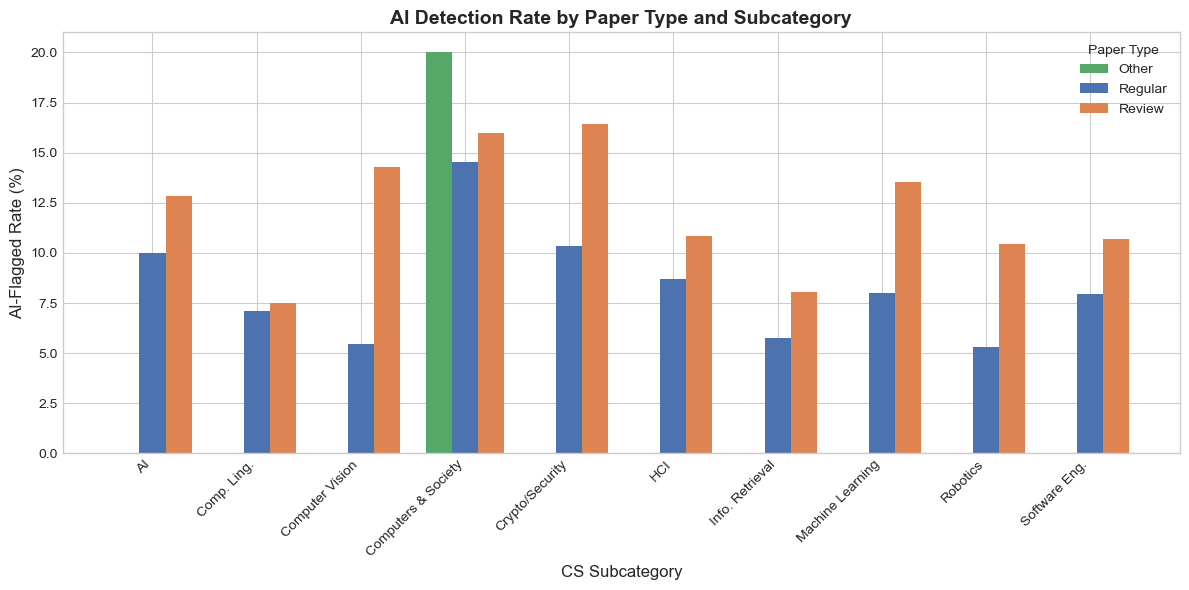

In [23]:
# Compare AI rates between regular and review papers
ai_by_type = df.groupby(['category_name', 'paper_type']).agg(
    count=('arxiv_id', 'count'),
    ai_rate=('is_ai_flagged', 'mean')
).reset_index()

# Pivot for grouped bar chart
ai_pivot = ai_by_type.pivot(index='category_name', columns='paper_type', values='ai_rate').fillna(0)

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(ai_pivot.index))
width = 0.25

colors = {'regular': '#4C72B0', 'review': '#DD8452', 'other': '#55A868'}
for i, col in enumerate(ai_pivot.columns):
    ax.bar(x + i * width, ai_pivot[col] * 100, width, label=col.title(), color=colors.get(col, 'gray'))

ax.set_xlabel('CS Subcategory', fontsize=12)
ax.set_ylabel('AI-Flagged Rate (%)', fontsize=12)
ax.set_title('AI Detection Rate by Paper Type and Subcategory', fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(ai_pivot.index, rotation=45, ha='right')
ax.legend(title='Paper Type')

plt.tight_layout()
plt.savefig('../figures/ai_rate_by_paper_type.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 5. Potential Policy Impact Score

A combined metric showing which subcategories face the highest burden from the policy.

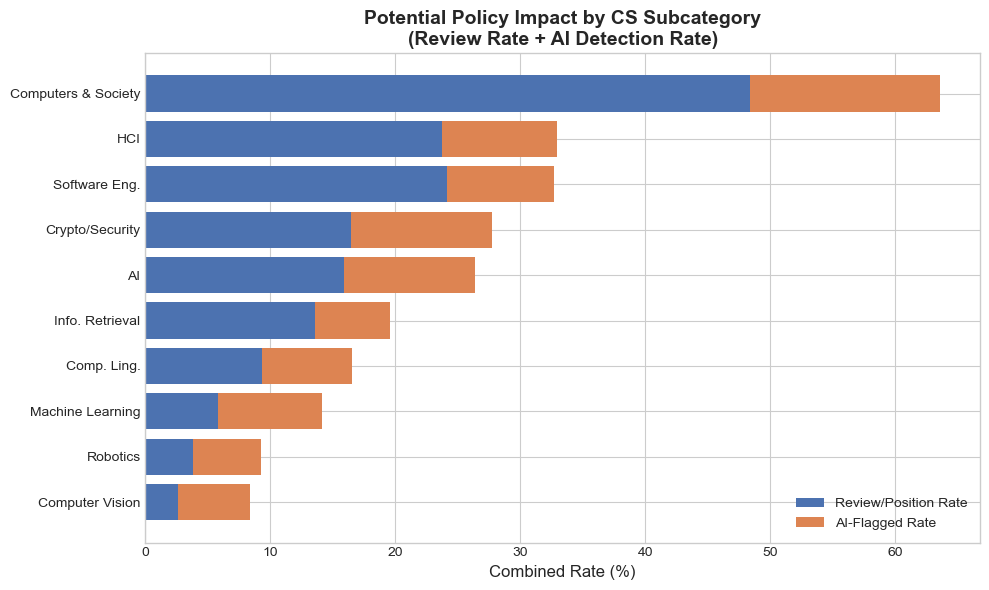

In [24]:
# Calculate impact score: combines review rate with AI flag rate
# Higher score = more papers affected by policy (reviews) AND higher false positive risk (if AI detection is flawed)
combined['impact_score'] = combined['review_rate'] + combined['ai_rate']
combined['affected_papers'] = combined['review_papers'] + combined['ai_flagged']

combined_sorted = combined.sort_values('impact_score', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))

# Stacked bar chart
bars1 = ax.barh(combined_sorted['category_name'], combined_sorted['review_rate'] * 100, 
                label='Review/Position Rate', color='#4C72B0')
bars2 = ax.barh(combined_sorted['category_name'], combined_sorted['ai_rate'] * 100,
                left=combined_sorted['review_rate'] * 100,
                label='AI-Flagged Rate', color='#DD8452')

ax.set_xlabel('Combined Rate (%)', fontsize=12)
ax.set_title('Potential Policy Impact by CS Subcategory\n(Review Rate + AI Detection Rate)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig('../figures/policy_impact_score.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 6. Summary Statistics Table

In [25]:
# Create summary table
summary = combined[['category_name', 'total_papers_rev', 'review_rate', 'ai_rate', 'impact_score']].copy()
summary.columns = ['Subcategory', 'Total Papers', 'Review Rate', 'AI Rate', 'Impact Score']
summary['Review Rate'] = (summary['Review Rate'] * 100).round(2).astype(str) + '%'
summary['AI Rate'] = (summary['AI Rate'] * 100).round(2).astype(str) + '%'
summary['Impact Score'] = (summary['Impact Score'] * 100).round(2).astype(str) + '%'
summary = summary.sort_values('Impact Score', ascending=False)

print("\n=== Summary Statistics ===")
print(summary.to_string(index=False))


=== Summary Statistics ===
        Subcategory  Total Papers Review Rate AI Rate Impact Score
           Robotics          4320       3.77%   5.49%        9.26%
    Computer Vision          4320       2.64%   5.69%        8.33%
Computers & Society          3028      48.38%  15.22%       63.61%
                HCI          4157      23.72%   9.21%       32.93%
      Software Eng.          4242      24.12%    8.6%       32.72%
    Crypto/Security          4268      16.42%  11.34%       27.76%
                 AI          4218      15.88%  10.46%       26.34%
    Info. Retrieval          3406      13.56%   6.05%       19.61%
        Comp. Ling.          4320       9.35%   7.15%        16.5%
   Machine Learning          4228       5.82%   8.33%       14.14%


## 7. Heatmap: AI Prediction Categories by Subcategory

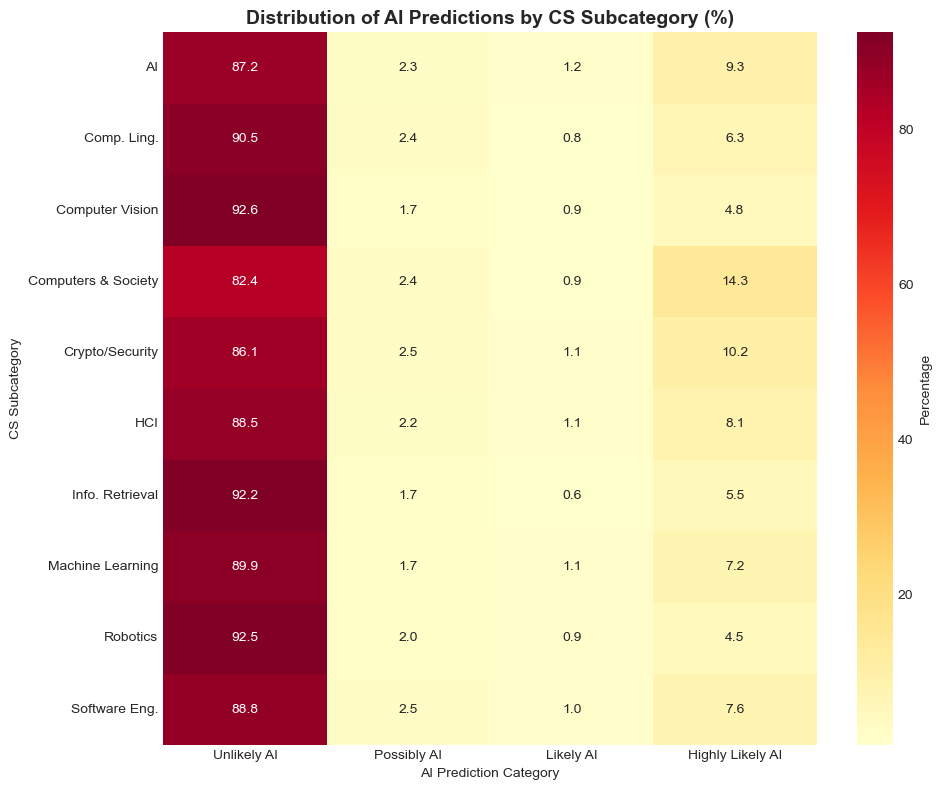

In [26]:
# Create heatmap of AI prediction distribution
pred_dist = df.groupby(['category_name', 'ai_prediction']).size().unstack(fill_value=0)
pred_dist_pct = pred_dist.div(pred_dist.sum(axis=1), axis=0) * 100

# Reorder columns
col_order = ['Unlikely AI', 'Possibly AI', 'Likely AI', 'Highly Likely AI']
pred_dist_pct = pred_dist_pct[[c for c in col_order if c in pred_dist_pct.columns]]

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(pred_dist_pct, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Percentage'}, ax=ax)
ax.set_title('Distribution of AI Predictions by CS Subcategory (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('AI Prediction Category')
ax.set_ylabel('CS Subcategory')

plt.tight_layout()
plt.savefig('../figures/ai_prediction_heatmap.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 8. Year-by-Year Analysis: Review Rates Over Time

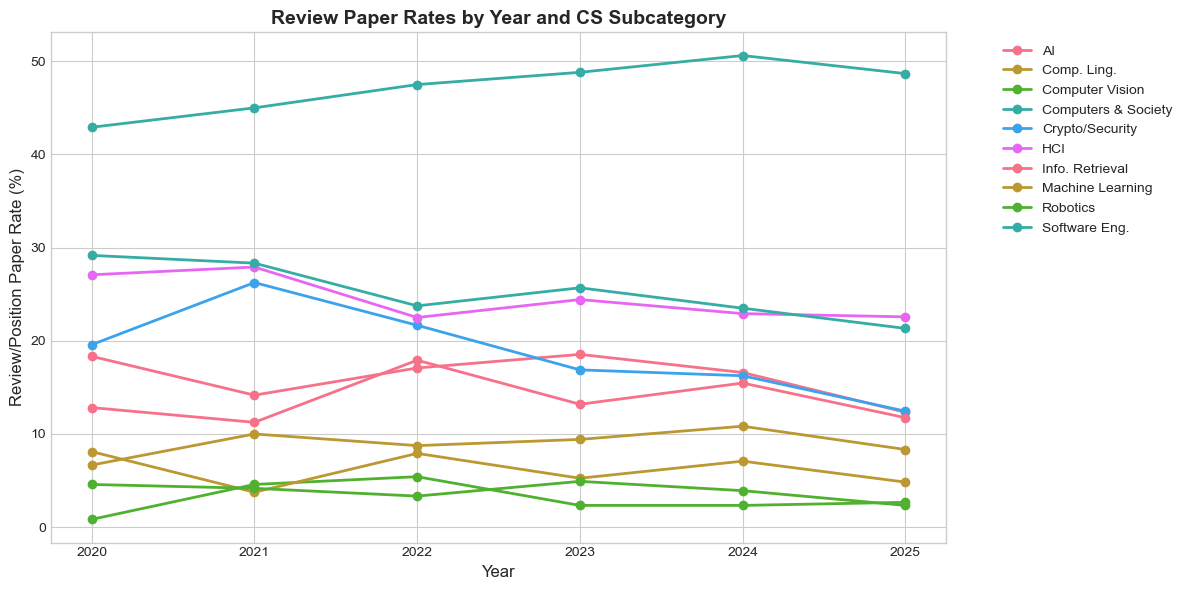

In [27]:
# Review rates by year and category
review_by_year = df.groupby(['year', 'category_name']).agg(
    total_papers=('arxiv_id', 'count'),
    review_rate=('is_review', 'mean')
).reset_index()

fig, ax = plt.subplots(figsize=(12, 6))

for cat in review_by_year['category_name'].unique():
    data = review_by_year[review_by_year['category_name'] == cat]
    ax.plot(data['year'], data['review_rate'] * 100, marker='o', label=cat, linewidth=2)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Review/Position Paper Rate (%)', fontsize=12)
ax.set_title('Review Paper Rates by Year and CS Subcategory', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticks(review_by_year['year'].unique())

plt.tight_layout()
plt.savefig('../figures/review_rates_by_year.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 9. Year-by-Year Analysis: AI Detection Rates Over Time

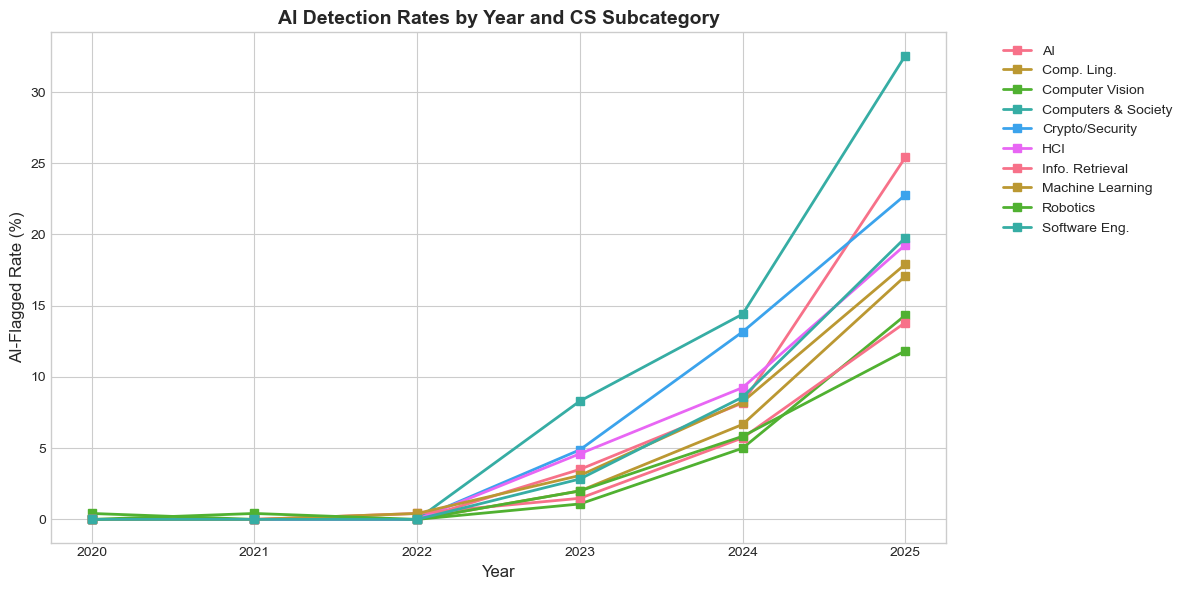

In [28]:
# AI detection rates by year and category
ai_by_year = df.groupby(['year', 'category_name']).agg(
    total_papers=('arxiv_id', 'count'),
    ai_rate=('is_ai_flagged', 'mean')
).reset_index()

fig, ax = plt.subplots(figsize=(12, 6))

for cat in ai_by_year['category_name'].unique():
    data = ai_by_year[ai_by_year['category_name'] == cat]
    ax.plot(data['year'], data['ai_rate'] * 100, marker='s', label=cat, linewidth=2)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('AI-Flagged Rate (%)', fontsize=12)
ax.set_title('AI Detection Rates by Year and CS Subcategory', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticks(ai_by_year['year'].unique())

plt.tight_layout()
plt.savefig('../figures/ai_rates_by_year.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 10. Year-by-Year Trends: Combined Impact Over Time

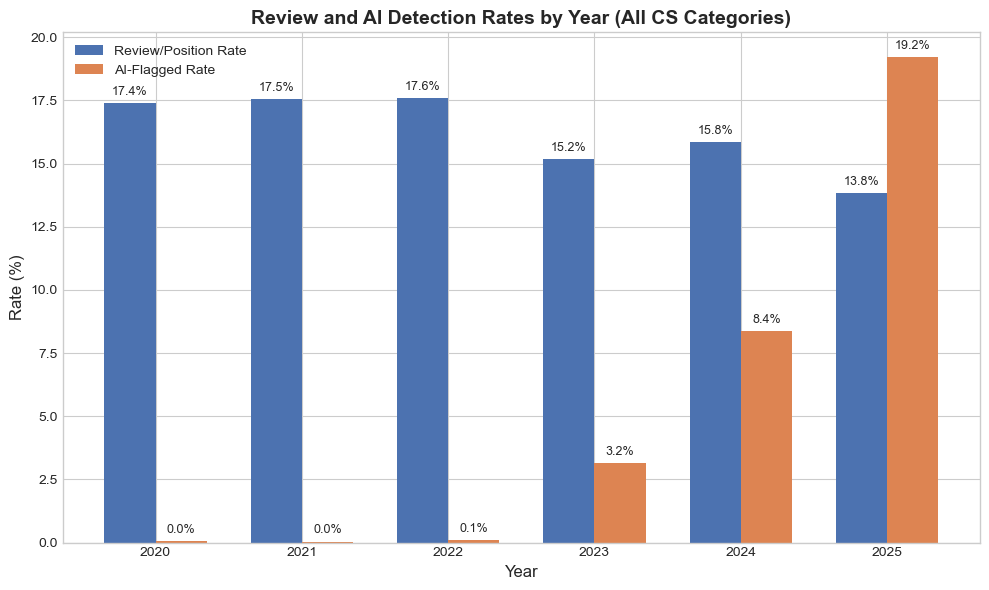

In [29]:
# Combined view: grouped bar chart showing both metrics by year
yearly_stats = df.groupby('year').agg(
    total_papers=('arxiv_id', 'count'),
    review_rate=('is_review', 'mean'),
    ai_rate=('is_ai_flagged', 'mean')
).reset_index()

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(yearly_stats['year']))
width = 0.35

bars1 = ax.bar(x - width/2, yearly_stats['review_rate'] * 100, width, 
               label='Review/Position Rate', color='#4C72B0')
bars2 = ax.bar(x + width/2, yearly_stats['ai_rate'] * 100, width,
               label='AI-Flagged Rate', color='#DD8452')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Rate (%)', fontsize=12)
ax.set_title('Review and AI Detection Rates by Year (All CS Categories)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(yearly_stats['year'])
ax.legend()

# Add value labels
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
            f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
            f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../figures/rates_by_year_combined.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 8. Year-by-Year Analysis: Review Rates Over Time

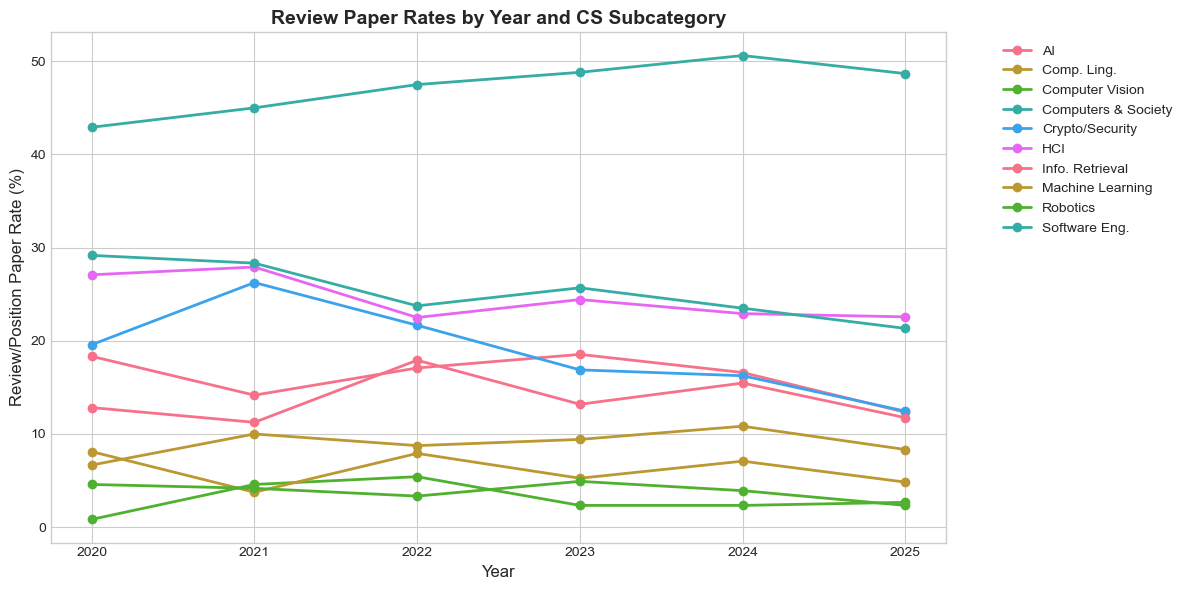

In [30]:
# Review rates by year and category
review_by_year = df.groupby(['year', 'category_name']).agg(
    total_papers=('arxiv_id', 'count'),
    review_rate=('is_review', 'mean')
).reset_index()

fig, ax = plt.subplots(figsize=(12, 6))

for cat in review_by_year['category_name'].unique():
    data = review_by_year[review_by_year['category_name'] == cat]
    ax.plot(data['year'], data['review_rate'] * 100, marker='o', label=cat, linewidth=2)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Review/Position Paper Rate (%)', fontsize=12)
ax.set_title('Review Paper Rates by Year and CS Subcategory', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticks(review_by_year['year'].unique())

plt.tight_layout()
plt.savefig('../figures/review_rates_by_year.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 9. Year-by-Year Analysis: AI Detection Rates Over Time

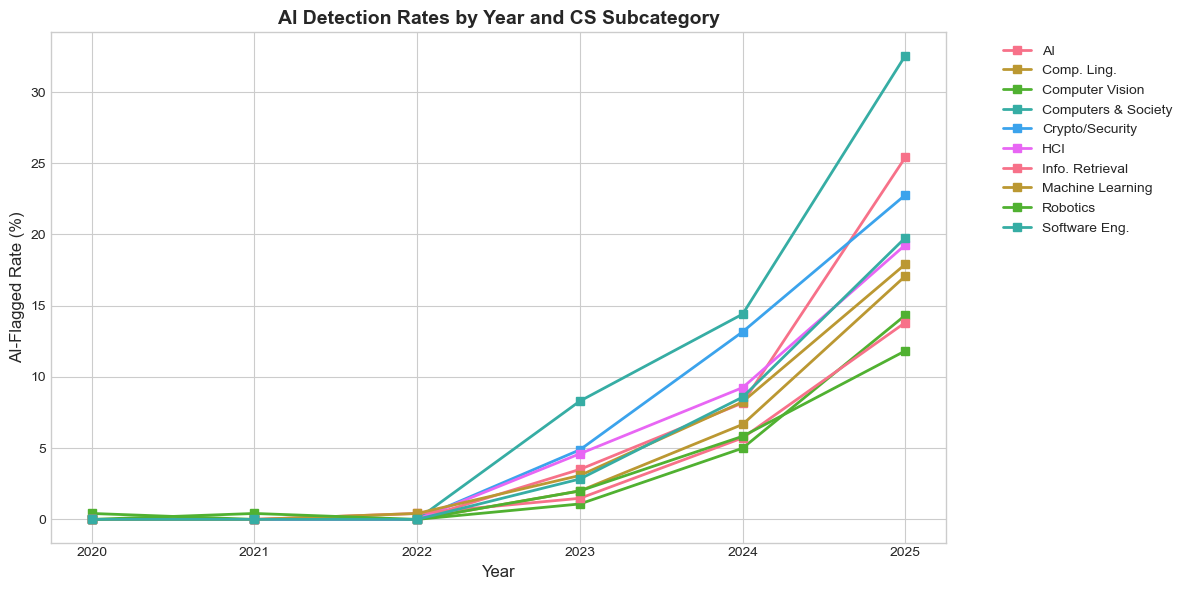

In [31]:
# AI detection rates by year and category
ai_by_year = df.groupby(['year', 'category_name']).agg(
    total_papers=('arxiv_id', 'count'),
    ai_rate=('is_ai_flagged', 'mean')
).reset_index()

fig, ax = plt.subplots(figsize=(12, 6))

for cat in ai_by_year['category_name'].unique():
    data = ai_by_year[ai_by_year['category_name'] == cat]
    ax.plot(data['year'], data['ai_rate'] * 100, marker='s', label=cat, linewidth=2)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('AI-Flagged Rate (%)', fontsize=12)
ax.set_title('AI Detection Rates by Year and CS Subcategory', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticks(ai_by_year['year'].unique())

plt.tight_layout()
plt.savefig('../figures/ai_rates_by_year.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 10. Year-by-Year Trends: Combined Impact Over Time

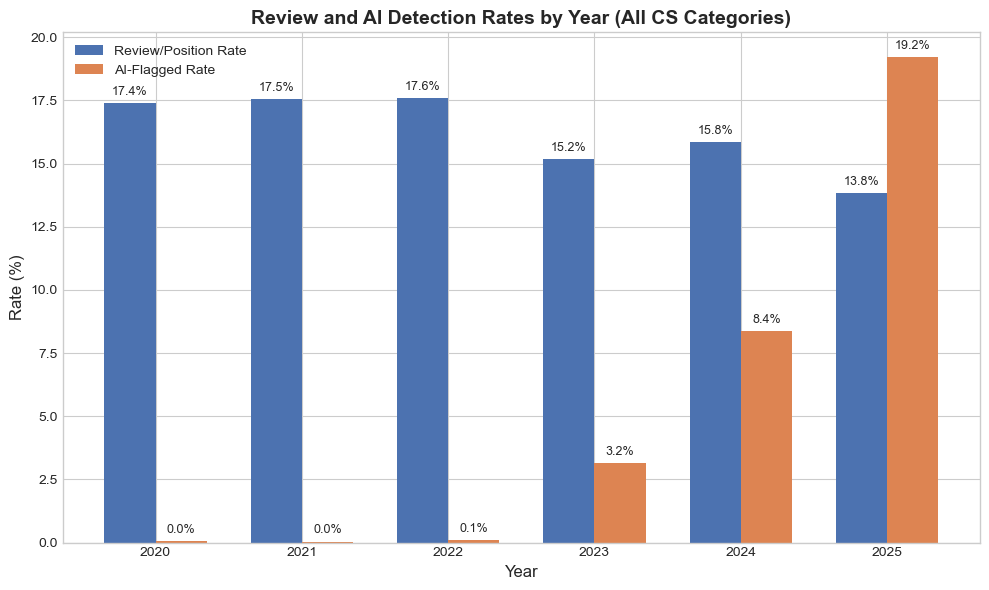

In [32]:
# Combined view: grouped bar chart showing both metrics by year
yearly_stats = df.groupby('year').agg(
    total_papers=('arxiv_id', 'count'),
    review_rate=('is_review', 'mean'),
    ai_rate=('is_ai_flagged', 'mean')
).reset_index()

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(yearly_stats['year']))
width = 0.35

bars1 = ax.bar(x - width/2, yearly_stats['review_rate'] * 100, width, 
               label='Review/Position Rate', color='#4C72B0')
bars2 = ax.bar(x + width/2, yearly_stats['ai_rate'] * 100, width,
               label='AI-Flagged Rate', color='#DD8452')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Rate (%)', fontsize=12)
ax.set_title('Review and AI Detection Rates by Year (All CS Categories)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(yearly_stats['year'])
ax.legend()

# Add value labels
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
            f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
            f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../figures/rates_by_year_combined.pdf', dpi=300, bbox_inches='tight')
plt.show()